In [26]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-31'


EIIE_MODEL = "trained_eiie/policy_EIIE_2022-12-31_1_2024-11-24 03_37_26.pt"

GRAPH_TITLE = "EIIE Trained 2009-2022, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (2760, 8)


# Portfolio Optimization Algorithm

In [27]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.35181855 0.27963358 0.2540565  0.27536942 0.22213764 0.20050276
 0.21795821 0.22398526 0.18140366 0.19971953 0.21862941 0.18288069
 0.25173724 0.25655932 0.20846969 0.20647458 0.16977883 0.22140022
 0.20087649 0.20671056 0.24370411 0.37134127 0.48436472 0.2192115
 0.26146174 0.20120535 0.1757472  0.18027714 0.19517704 0.19363506
 0.20576698 0.21390712 0.18559093 0.18472204 0.16007065 0.15185834
 0.17406055 0.14120282 0.15861371 0.17409005 0.16392028 0.22195407
 0.27475219 0.17629603 0.14812607 0.16892688 0.21517642 0.26502173
 0.23125368 0.24214863 0.23898934 0.31048271 0.23108266 0.23201432
 0.23754809 0.21219443 0.18575536 0.16439788 0.14432099 0.16099446
 0.15533361 0.21573309 0.17878818 0.14521876 0.16164088 0.14243164
 0.14973301 0.14950488 0.1573

In [28]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_6880\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=t

<All keys matched successfully>

In [29]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1435230.125
Final accumulative portfolio value: 1.435230125
Maximum DrawDown: -0.15506297789176893
Sharpe ratio: 1.2875691593512806
Total commission cost: 13555.485779759241


In [30]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2023-03-15
1      1.062294e+06 2023-03-16
2      1.049274e+06 2023-03-17
3      1.026394e+06 2023-03-20
4      1.001761e+06 2023-03-21
..              ...        ...
406    1.434457e+06 2024-10-24
407    1.436047e+06 2024-10-25
408    1.434660e+06 2024-10-28
409    1.436402e+06 2024-10-29
410    1.435230e+06 2024-10-30

[411 rows x 2 columns]


In [31]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2023-03-15 00:00:00
2024-10-30 00:00:00


In [32]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test_split = data_split(processed_test, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test_split,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)



# PPO Model

In [33]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR

TRAINED_PPO = "/2022_train/model_checkpoint_3000000_steps"

test_ppo_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test_split)


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 


environment_ppo = PortfolioOptimizationEnv(
    test_ppo_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.24214863 0.23898934 0.31048271 0.23108266 0.23201432 0.23754809
 0.21219443 0.18575536 0.16439788 0.14432099 0.16099446 0.15533361
 0.21573309 0.17878818 0.14521876 0.16164088 0.14243164 0.14973301
 0.14950488 0.15731491 0.21477853 0.15497212 0.13027555 0.15665563
 0.14974336 0.1646053  0.18305924 0.13163554 0.15286217 0.14277273
 0.20365985 0.17324343 0.16465707 0.15195718 0.20439319 0.25491222
 0.35558063 0.17560819 0.14223332 0.16858453 0.15537441 0.14276959
 0.11694086 0.13213981 0.18184893 0.20552504 0.17501072 0.13672309
 0.15924224 0.14165782 0.17590786 0.17206921 0.17561321 0.31261871
 0.21621006 0.19438283 0.38266141 0.20349071 0.19437875 0.15757159
 0.15335357 0.17031165 0.17236449 0.18031542 0.20532578 0.31767175
 0.15626684 0.15537754 0.160

Initial portfolio value:1000000
Final portfolio value: 1221939.25
Final accumulative portfolio value: 1.22193925
Maximum DrawDown: -0.1035779972062314
Sharpe ratio: 1.165319643592662
Total commission cost: 8648.363186249975
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2023-03-15
1         1.017115e+06 2023-03-16
2         1.017033e+06 2023-03-17
3         1.017834e+06 2023-03-20
4         1.019566e+06 2023-03-21
..                 ...        ...
406       1.220667e+06 2024-10-24
407       1.221945e+06 2024-10-25
408       1.218797e+06 2024-10-28
409       1.220778e+06 2024-10-29
410       1.221939e+06 2024-10-30

[411 rows x 2 columns]


# Porfolio Baselines

In [34]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1299427.625
Final accumulative portfolio value: 1.299427625
Maximum DrawDown: -0.15541295596567506
Sharpe ratio: 1.1264958977291923
Total commission cost: 4910.084951351979
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2023-03-15
1         1.024328e+06 2023-03-16
2         1.022820e+06 2023-03-17
3         1.022926e+06 2023-03-20
4         1.024155e+06 2023-03-21
..                 ...        ...
406       1.296317e+06 2024-10-24
407       1.299344e+06 2024-10-25
408       1.299186e+06 2024-10-28
409       1.300738e+06 2024-10-29
410       1.299428e+06 2024-10-30

[411 rows x 2 columns]


In [35]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1316098.25
Final accumulative portfolio value: 1.31609825
Maximum DrawDown: -0.14359303203234208
Sharpe ratio: 1.211871731257461
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2023-03-15
1         1.024328e+06 2023-03-16
2         1.022756e+06 2023-03-17
3         1.022548e+06 2023-03-20
4         1.023755e+06 2023-03-21
..                 ...        ...
406       1.313313e+06 2024-10-24
407       1.315185e+06 2024-10-25
408       1.316987e+06 2024-10-28
409       1.316840e+06 2024-10-29
410       1.316098e+06 2024-10-30

[411 rows x 2 columns]


In [36]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 721781.25
Final accumulative portfolio value: 0.72178125
Maximum DrawDown: -0.5538399948159491
Sharpe ratio: -0.38970084293553475
Total commission cost: 401107.56015295326
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2023-03-15
1           1.024328e+06 2023-03-16
2           1.010097e+06 2023-03-17
3           9.821032e+05 2023-03-20
4           9.798048e+05 2023-03-21
..                   ...        ...
406         7.379921e+05 2024-10-24
407         7.356152e+05 2024-10-25
408         7.151142e+05 2024-10-28
409         7.259816e+05 2024-10-29
410         7.217812e+05 2024-10-30

[411 rows x 2 columns]


In [37]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 803460.625
Final accumulative portfolio value: 0.803460625
Maximum DrawDown: -0.34826181836532555
Sharpe ratio: -0.3958560980320335
Total commission cost: 42530.059811582905
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2023-03-15
1         1.024328e+06 2023-03-16
2         1.010097e+06 2023-03-17
3         9.821032e+05 2023-03-20
4         9.798048e+05 2023-03-21
..                 ...        ...
406       8.197490e+05 2024-10-24
407       8.145170e+05 2024-10-25
408       8.168862e+05 2024-10-28
409       8.065208e+05 2024-10-29
410       8.034606e+05 2024-10-30

[411 rows x 2 columns]


In [38]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 960128.9375
Final accumulative portfolio value: 0.9601289375
Maximum DrawDown: -0.2616934060291166
Sharpe ratio: 0.03346376332670911
Total commission cost: 21432.141050994396
hit end!
     bnn_opt_net_worth       Date
0         1000000.0000 2023-03-15
1         1000000.0000 2023-03-16
2         1000000.0000 2023-03-17
3         1000000.0000 2023-03-20
4         1000000.0000 2023-03-21
..                 ...        ...
406        979593.3750 2024-10-24
407        973341.1250 2024-10-25
408        976172.3125 2024-10-28
409        963785.8125 2024-10-29
410        960128.9375 2024-10-30

[411 rows x 2 columns]


In [39]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_hist_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp_hist = DRLStableAgent(env = environment_benchmarks)
model_scrp_hist = agent_scrp_hist.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp_hist, environment_benchmarks)
SCRP_hist_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_hist_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_hist_opt = pd.DataFrame(SCRP_hist_results["test"]["value"], columns=['scrp_hist_opt_net_worth'])
df_scrp_hist_date = pd.DataFrame(SCRP_hist_results["test"]["date"], columns=['Date'])
if len(df_scrp_hist_opt) == len(df_scrp_hist_date):
    df_scrp_hist_opt['Date'] = df_scrp_hist_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_hist_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_hist_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_hist_opt.loc[len(df_scrp_hist_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (19926, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 17718768.0
Final accumulative portfolio value: 17.718768
Maximum DrawDown: -0.43797173457294036
Sharpe ratio: 0.9003792307927965
Total commission cost: 3938.2438087625196
hit end!
               0           1          2           3           4          5
0       6.447412   43.777550  13.519426   23.300682   19.785192  13.113418
1       6.458559   45.211346  13.512951   23.308210   19.558475  12.982834
2       6.355827   46.582806  13.467626   23.165169   19.295832  12.953817
3       6.344077   48.468563  13.338129   22.924253   19.475420  12.961073
4       6.386255   48.001011  13.487052   23.082359   19.529303  12.895783
...          ...         ...        ...         ...         ...        ...
3316  151.510132  207.199997  25.357193  250.228912  219.195770  44.903976
3317  149.250412  201.240005  25.806166  248.867813  217.045135  44.601578
3318  147.179016  203.070007  26.567465  245.188812  213.227310  44.536549
3319  149.13148

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1515855.5
Final accumulative portfolio value: 1.5158555
Maximum DrawDown: -0.16606615507572098
Sharpe ratio: 1.297770743465371
Total commission cost: 0.01521632622461766
hit end!
     scrp_hist_opt_net_worth       Date
0                1000000.000 2023-03-15
1                1018694.375 2023-03-16
2                1013138.375 2023-03-17
3                1028825.625 2023-03-20
4                1041114.125 2023-03-21
..                       ...        ...
406              1518951.750 2024-10-24
407              1524485.500 2024-10-25
408              1537595.125 2024-10-28
409              1539373.875 2024-10-29
410              1515855.500 2024-10-30

[411 rows x 2 columns]


In [40]:
# SCRP - no history

SCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 933160.5625
Final accumulative portfolio value: 0.9331605625
Maximum DrawDown: -0.3111619136272863
Sharpe ratio: -0.03423088273893873
Total commission cost: 11685.746082195663
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2023-03-15
1          1.024328e+06 2023-03-16
2          1.010097e+06 2023-03-17
3          9.880722e+05 2023-03-20
4          9.643530e+05 2023-03-21
..                  ...        ...
406        9.163325e+05 2024-10-24
407        9.237109e+05 2024-10-25
408        9.203453e+05 2024-10-28
409        9.319092e+05 2024-10-29
410        9.331606e+05 2024-10-30

[411 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [41]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1792548.5
Final accumulative portfolio value: 1.7925485
Maximum DrawDown: -0.10813799053296325
Sharpe ratio: 2.2486924235912307
Total commission cost: 0.0
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2023-03-15
1          9.943194e+05 2023-03-16
2          1.002373e+06 2023-03-17
3          1.013159e+06 2023-03-20
4          1.009707e+06 2023-03-21
..                  ...        ...
406        1.828888e+06 2024-10-24
407        1.817216e+06 2024-10-25
408        1.822501e+06 2024-10-28
409        1.799376e+06 2024-10-29
410        1.792548e+06 2024-10-30

[411 rows x 2 columns]


# Stock environment optimization algorithm

In [42]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (410, 8)
Annual return          0.188812
Cumulative returns     0.324976
Annual volatility      0.106542
Sharpe ratio           1.681009
Calmar ratio           2.093782
Stability              0.893537
Max drawdown          -0.090178
Omega ratio            1.315902
Sortino ratio          2.542477
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.100729
Daily value at risk   -0.012712
dtype: float64
df_dji:            date           dji
0   2023-03-15  1.000000e+06
1   2023-03-16  1.011670e+06
2   2023-03-17  9.996050e+05
3   2023-03-20  1.011608e+06
4   2023-03-21  1.021523e+06
..         ...           ...
406 2024-10-24  1.329410e+06
407 2024-10-25  1.321254e+06
408 2024-10-28  1.329824e+06
409 2024-10-29  1.324976e+06
410 2024-10-30           NaN

[411 rows x 2 columns]
df_dji:                       dji
date                    
2023-03-15  1.000000e+06
2023-03-16  1.011670e+06
2023-03-17  9.996050e+05
2023-03-20  1.011608e+06

# Compare all results

In [43]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the baseline SCRP hist algorithm
df_scrp_hist_opt['Date'] = pd.to_datetime(df_scrp_hist_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_hist_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2023-03-15  1.000000e+06
2023-03-16  1.011670e+06
2023-03-17  9.996050e+05
2023-03-20  1.011608e+06
2023-03-21  1.021523e+06
...                  ...
2024-10-24  1.329410e+06
2024-10-25  1.321254e+06
2024-10-28  1.329824e+06
2024-10-29  1.324976e+06
2024-10-30           NaN

[411 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2023-03-15        1.000000e+06       1.000000e+06   
1         1.024328e+06 2023-03-16        9.943194e+05       1.024328e+06   
2         1.022820e+06 2023-03-17        1.002373e+06       1.022756e+06   
3         1.022926e+06 2023-03-20        1.013159e+06       1.022548e+06   
4         1.024155e+06 2023-03-21        1.009707e+06       1.023755e+06   
..                 ...        ...                 ...                ...   
406       1.296317e+06 2024-10-24        1.828888e+06       1.313313e+06   
407       1.299344e+06 2024-10-25        1.

# Baseline CRP in the environment

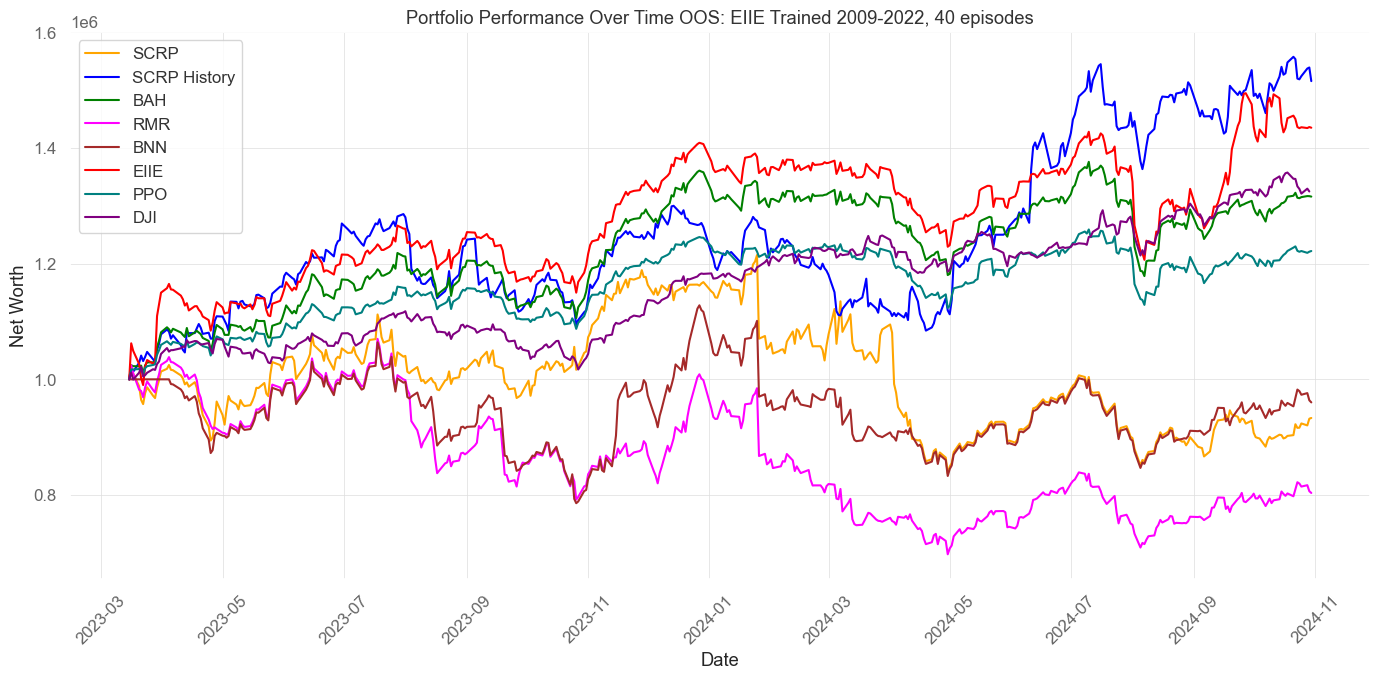

In [44]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'BAH': 'green',
    'EIIE': 'red',
    'PPO': 'teal',
    'DJI': 'purple',
    'SCRP': 'orange',
    'SCRP History': 'blue',
    'OLMAR': 'cyan',
    'RMR': 'magenta',
    'BNN': 'brown'
}




plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP', color=color_map['CRP'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP', color=color_map['SCRP'])
plt.plot(merged_df['Date'], merged_df['scrp_hist_opt_net_worth'], label='SCRP History', color=color_map['SCRP History'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH', color=color_map['BAH'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR', color=color_map['OLMAR'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR', color=color_map['RMR'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN', color=color_map['BNN'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE', color=color_map['EIIE'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO', color=color_map['PPO'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI', color=color_map['DJI'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'Hist. SCRP': merged_df['scrp_hist_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
    'PPO': merged_df['ppo_opt_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 1316098.25,
 'BCRP OPT': 1792548.5,
 'BNN': 960128.9375,
 'CRP': 1299427.625,
 'EIIE': 1435230.125,
 'Hist. SCRP': 1515855.5,
 'OLMAR': 721781.25,
 'PPO': 1221939.25,
 'RMR': 803460.625,
 'SCRP': 933160.5625}


In [46]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()
merged_df['SCRP_hist_opt_daily_return'] = merged_df['scrp_hist_opt_net_worth'].pct_change()


merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['PPO_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


  

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_hist_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['PPO_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 1.0784438244804653,
 'BCRP': 2.1306425812734178,
 'BNN': -0.04397916730653483,
 'CRP': 0.997329033568191,
 'EIIE': 1.1813898382209609,
 'Hist. SCRP': 1.206106416326945,
 'OLMAR': -0.4477221012537791,
 'PPO': 0.9863727160613944,
 'RMR': -0.4745443782960387,
 'SCRP': -0.11186092471794748}


In [47]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_hist_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.14359303203234208,
 'BCRP': -0.10813799053296325,
 'BNN': -0.2616934060291166,
 'CRP': -0.15541295596567506,
 'EIIE': -0.15506297789176893,
 'Hist. SCRP': -0.16606615507572098,
 'OLMAR': -0.5538399948159491,
 'PPO': -0.1035779972062314,
 'RMR': -0.34826181836532555,
 'SCRP': -0.3111619136272863}


In [48]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'Hist. SCRP': calculate_up_days_ratio(merged_df['SCRP_hist_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'PPO': calculate_up_days_ratio(merged_df['PPO_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.5585365853658537,
 'BCRP': 0.5682926829268292,
 'BNN': 0.5195121951219512,
 'CRP': 0.5560975609756098,
 'EIIE': 0.5414634146341464,
 'Hist. SCRP': 0.5487804878048781,
 'OLMAR': 0.5097560975609756,
 'PPO': 0.5365853658536586,
 'RMR': 0.5219512195121951,
 'SCRP': 0.5463414634146342}


In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000011    1.0  0.101712  0.749866
Residual   0.091579  818.0       NaN       NaN


In [50]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.024328
2     -0.001535
3     -0.000204
4      0.001181
5     -0.013853
         ...   
406   -0.000602
407    0.001426
408    0.001370
409   -0.000112
410   -0.000563
Name: BAH_opt_daily_return, Length: 410, dtype: float64
t-statistic: 0.3189238217407436
p-value: 0.7498656982761325
